# <span style="color:Maroon">ПРОЕКТ: Поиск токсичных комментариев</span>

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.<br><br>
<b>Цель данного проекта</b> - Необходимо создать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.<br><br>    
Заказчику важны:<br>
<li>Модель со значением метрики качества <b><i>F1</i></b> не меньше <b><i>0.75</i></b>.<br><br>
<span style="color:Maroon"><b>1 Загрузить и подготовить данные:</b></span><br><br>
<li>Проверить состав предоставленной выбороки;
<li>Проанализировать данные;
<li>Провести предобработку данных;
<li>Описать результаты.<br><br>        
<span style="color:Maroon"><b>2 Обучить модель и выбрать лучшую:</b></span><br><br>    
<li>Обучите разные модели на базовых настройках;
<li>Обучите разные модели на с подбором гиперпараметров;
<li>Подобрать для моделей оптимальные гиперпараметры;
<li>Оценить качество моделей кросс-валидацией;
<li>Выбрать лучшую модель
<li>Сделать выводы.<br><br>    
<span style="color:Maroon"><b>3 Тестирование лучшей модели:</b></span><br><br>    
<li>Проверить модель на тестовой выборке;
<li>Проанализировать предсказания выбранной модели;
<li>Написать выводы и обосновать выбор.  
</div>

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
создам стиль для отображения табличных данных
</div>

In [1]:
cell_hover     = {'selector': 'td:hover',
                  'props'   : [('background', '#9E4447'), 
                               ('color', '#ffffff')]}           # формат выделенной ячейки

row_hover      = {'selector': 'tr:hover',
                  'props'   : [('background', '#808080'), 
                               ('color', '#ffffff')]}           # формат выделенной строки

color_row_even = {'selector': 'tr:nth-of-type(even)',
                  'props'   : [('background', '#D9D9D9'),
                               ('color', 'black')]}             # формат нечетных строк

color_row_odd  = {'selector': 'tr:nth-of-type(odd)',
                  'props'   : [('background', '#ffffff'),
                               ('color', '#363636')]}           # формат четных строк

index_names    = {'selector': 'th',
                  'props'   : [('background', '#363636'), 
                               ('color', '#ffffff'),  
                               ('text-align','center')]}        # формат заголовка и индекса

border_inner   = {'selector': 'td',
                  'props'   : [('border','1px dashed #363636')]}# формат границы таблицы

border_outer   = {'selector': '',
                  'props'   : [('border','2px solid #363636')]} # формат границы таблицы

caption        = {'selector': 'caption',
                  'props'   : [('color', '#363636'), 
                               ('font-size', '15px')]}

# передаю в переменную для дальнейшего использования
styler = [cell_hover, color_row_even, color_row_odd, index_names, row_hover, border_inner, border_outer, caption]

In [4]:
# библиотеки
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import torch
import transformers
import nltk
import warnings 
from matplotlib import pyplot as plt

# обработка
from transformers import BertModel
from transformers import BertTokenizer
from tqdm import notebook
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer   
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from PIL import Image
from nltk.corpus import stopwords as nltk_stopwords

# модели
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

# метрики
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from time import time

# настройки и параметры
toki_zer   = TweetTokenizer()
stop_words = set(nltk_stopwords.words('english'))
m          = WordNetLemmatizer()
RANDOM     = 1123581321
METRIC     = 'f1'
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to C:\Users\Stas
[nltk_data]     Che\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Stas
[nltk_data]     Che\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to C:\Users\Stas
[nltk_data]     Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузка и подготовка данных

## Загрузка данных и первый осмотр

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Предварительно подгружу библиотеку с предобученной моделью https://huggingface.co/unitary/toxic-bert
</div>

In [5]:
model = BertModel.from_pretrained('unitary/toxic-bert',output_hidden_states = True)

# инициализируем токенизатор
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
Далее загружаем датасет для работы
</div>

In [6]:
# вариативная загрузка данных
try:
    data_text = pd.read_csv('toxic_comments.csv')
except:
    data_text = pd.read_csv('/datasets/toxic_comments.csv')

In [7]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
'{:.2%}'.format(data_text.value_counts('toxic')[0] / data_text.shape[0])

'89.84%'

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Баланс классов в данных сильно искажен в сторону не токсичных комментариев
</div>

In [9]:
data_text['text_length'] = data_text['text'].apply(lambda x: len(str(x)))

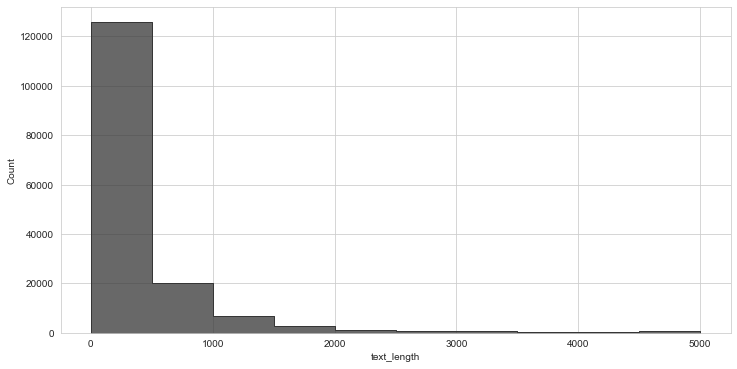

In [10]:
plt.figure(figsize = (12, 6))
sns.set_style('whitegrid')

sns.histplot(data_text['text_length'], 
             bins = 10, 
             color = '#363636', 
             element="step")
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
длина комментариев достигает 5000 символов, основное количество сосредоточено в районе 500 символов
</div>

## Облако слов

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Создам облако самых популярных слов в токсичных комментариях, для этого предварительно проведу очистку текста
</div>

In [11]:
aphost = { "aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", 
          "didn't" : "did not", "doesn't" : "does not", "don't" : "do not",
          "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not",
          "he'd" : "he would", "he'll" : "he will", "he's" : "he is",
          "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am",
          "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have",
          "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not",
          "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is",
          "shouldn't" : "should not", "that's" : "that is", "there's" : "there is",
          "they'd" : "they would", "they'll" : "they will", "they're" : "they are",
          "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not",
          "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is",
          "what've" : "what have", "where's" : "where is", "who'd" : "who would",
          "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have",
          "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would",
          "you'll" : "you will", "you're" : "you are", "you've" : "you have",
          "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not","tryin'":"trying"}

In [12]:
def clear_text(text):    
    
    clear_lemm_text = str(text.lower())    
    clear_lemm_text = re.sub(r'\\n','',clear_lemm_text)
    clear_lemm_text = re.sub(r'\\n\\n','',clear_lemm_text)
    clear_lemm_text = re.sub(r'\[\[.*\]','',clear_lemm_text)
    clear_lemm_text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}','',clear_lemm_text)
    clear_lemm_text = re.sub(r'[^a-zA-Z]',' ',clear_lemm_text)
    clear_lemm_text = re.sub(r' . ',' ',clear_lemm_text)
    
    words = toki_zer.tokenize(clear_lemm_text)    
    words = [aphost[word] if word in aphost else word for word in words]
    words = [m.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in stop_words]
    
    clear_lemm_text = " ".join(words)
    
    return clear_lemm_text

In [13]:
text_cloud = data_text[data_text['toxic'] == 1]
text_cloud['text'] = text_cloud['text'].apply(clear_text)

In [14]:
def word_cloud(data, path, label):
    mask = np.array(Image.open(path))
    text = " ".join(t for t in data)
    
    wordcloud = WordCloud(stopwords        = STOPWORDS, 
                          background_color = "white",
                          max_words        = 1000, 
                          mask             = mask).generate(text)

    image_colors = ImageColorGenerator(mask)
    
    plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = "bilinear")
    plt.title(label, fontsize = 14)
    plt.axis("off")

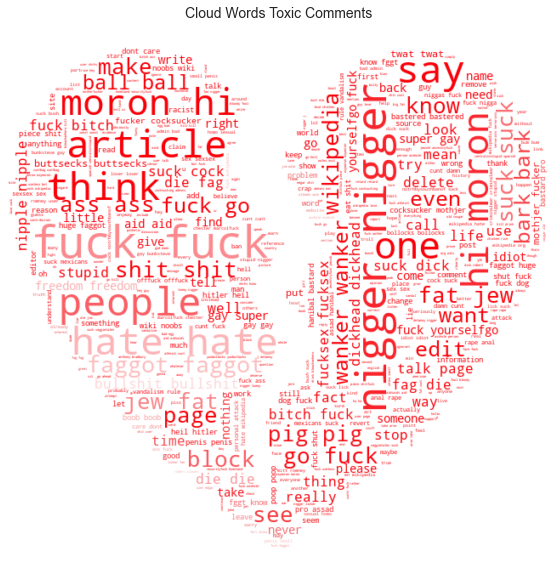

In [15]:
word_cloud(text_cloud['text'], 'heart.png', 'Cloud Words Toxic Comments')

## Подготовка признаков

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
В датасете огромное количество комментариев, это затруднит подготовку текста и обучение моделей, поэтому я сделаю выборку из датасета с учетом дисбаланса классов которые были найдены на предыдущем этапе, соберу выборку из 1000 тыс. экземпляров случайным образом
</div>

In [16]:
text_sample = data_text.sample(1000, random_state = RANDOM)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Токенизируем каждый комментарий
</div>

In [17]:
tokenized = text_sample['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

максимальная длина вектора:512


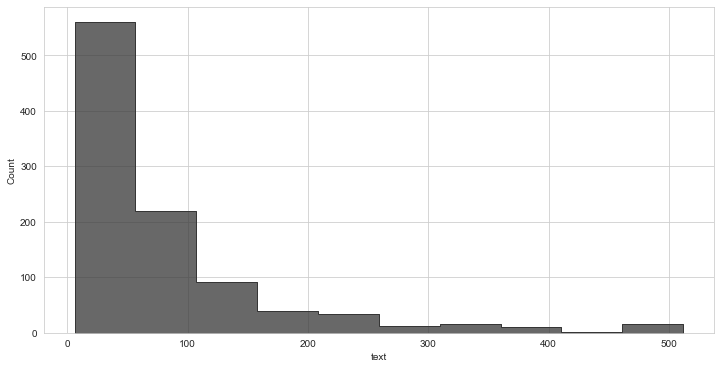

In [18]:
plt.figure(figsize = (12, 6))
sns.set_style('whitegrid')
ax = tokenized.str.len()
sns.histplot(ax, 
             bins = 10, 
             color = '#363636', 
             element="step")
print(f'максимальная длина вектора:{ax.max()}')
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Токены подготовлены, максимальная длина вектора составляет 512, далее необходимо применит метод <b>padding</b> к векторам и создать маску для выделения важных токенов, куда передадим размер самого длинного вектора
</div>

In [19]:
padded = np.array([i + [0]*(ax.max() - len(i)) for i in tokenized.values])

In [20]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Проверим размеры матриц
</div>

In [21]:
padded.shape[0] == attention_mask.shape[0]

True

In [22]:
padded.shape[0] == attention_mask.shape[0] == tokenized.shape[0]

True

## Эмбеддинг

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Начнём преобразование текстов в эмбеддинги. Эмбеддинги модель <b>BERT</b> создаёт батчами, чтобы хватило оперативной памяти, сделаем размер батча небольшим.
   
Преобразуем данные в формат тензоров в библиотеке <b>torch</b>, которые передадим модели, далее из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
</div>

In [23]:
%%time
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    
        batch = torch.LongTensor(padded[batch_size * i : batch_size * (i + 1)])
        
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1)])
        
        with torch.no_grad():
            
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 15min 36s


<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Соберём все эмбеддинги в матрицу признаков
</div>

In [24]:
np.save('embeddings.npy', embeddings)

In [25]:
embeddings = np.load('embeddings.npy')

In [26]:
features = np.concatenate(embeddings)
target   =  text_sample['toxic']

In [27]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size    = 0.5, 
                                                                            random_state = RANDOM,
                                                                            stratify     = target)

In [28]:
target_train.value_counts(), target_test.value_counts()

(0    447
 1     53
 Name: toxic, dtype: int64,
 0    447
 1     53
 Name: toxic, dtype: int64)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
проверка содержание классов в тренировочной и тестовой выборках, показывает что распределение на уровне основного датасета, которые равномерно распределены в выборках - баланс соблюден
</div>

<div style="background-color:gray; border:solid #363636 2px; padding: 20px">      
<span style="color:white"><b>Выводы:</b></span><br><br>   
<span style="color:white">    
<li>Данные загружены;
<li>Данные отобраны для дальнейшей работы;
<li>Проведена токенизация;
<li>Проведен эмбеддинг;
<li>Проведена разбивка данных на тренировочную и тестовую;
<li>Признаки готовы, можно обучать модель!
</span>
</div>

# Обучение моделей

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
В данном проекте стоит задача классификации, для это я выбрал четыре модели <b>LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, LGBMClassifier, LinearSVC</b>. Основная задача подготовить и найти модель, у которой метрия <b>f1_score будет не ниже 0,75</b>, для автоматизированного процесса буду использовать <b>GridSearchCV</b>, для подбора параметров, предварительно создам функцию для расчета.<br><br>    
Так же хочу провести моделирование в несколько этапов, чтобы отследить изменение качества моделей на всем пути обучения
</div>

## Модели с базовыми параметрами

In [ ]:
def grid_search_model_score(models, parameters, scoring, features, target):
    
    scores  = []
    
    for i in notebook.tqdm(range(len(models))):

        grid_model = GridSearchCV(estimator  = models[i], 
                                  param_grid = parameters[i],
                                  scoring    = METRIC,
                                  n_jobs     = -1,
                                  cv         = 3)

        grid_model.fit(features, target)

        time_score    = grid_model.cv_results_['mean_test_score']    
        mean_fit_time = grid_model.cv_results_['mean_fit_time'][np.where(time_score == time_score.max())[0][0]]

        scores.append([' '.join(re.sub(r'([A-Z])', r' \1', str(models[i]).split('(')[0]).split()), 
                       grid_model.best_score_, 
                       mean_fit_time,
                       grid_model.best_params_])
    return scores

In [ ]:
classifiers  = [LogisticRegression(random_state = RANDOM),
                RandomForestClassifier(random_state = RANDOM),
                DecisionTreeClassifier(random_state = RANDOM),
                LinearSVC(random_state = RANDOM)]

In [ ]:
parameters = [{}] * len(classifiers)

In [ ]:
%%time
scores_base = grid_search_model_score(classifiers, 
                                      parameters, 
                                      METRIC, 
                                      features_train, 
                                      target_train)

In [ ]:
pd.DataFrame(data    = scores_base, 
             columns = ['model', 'f1', 'mean_fit_time', 'parameters'])\
            .sort_values(['f1', 'mean_fit_time'], ascending = [False, True])\
            .reset_index(drop = True)\
            .style\
            .format({'f1':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты моделей на базовых параметрах',)\
            .set_table_styles(styler)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
На базовых параметрах, все модели показывают отличный результат, выше заявленного, лидирует по качеству - модель на базовых параметрах <b>Logistic Regression</b>. Теперь необходимо постараться улучшить результаты с помощью подбора гиперпараметров для моделей
</div>

## Подбор гиперпараметров

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">
    
Далее буду перебирать параметры для моделей и на основании показателей качества моделей выберу лучшую
</div>

In [ ]:
scores_param = [['Logistic Regression',
                 0.962948662948663,
                 0.2546652952829997,
                 {'class_weight': 'balanced', 
                  'solver': 'newton-cg'}],
                
                ['Random Forest Classifier',
                 0.962948662948663,
                 4.378036737442017,
                 {'class_weight': 'balanced',
                  'max_depth': 5,
                  'max_features': 'sqrt',
                  'min_samples_leaf': 5,
                  'min_samples_split': 5,
                  'n_estimators': 500}],
                
                ['Decision Tree Classifier',
                 0.9258830258830258,
                 0.024000088373819988,
                 {'class_weight': None,
                  'max_depth': 5,
                  'max_features': 'log2',
                  'min_samples_leaf': 10,
                  'min_samples_split': 5}],
                
                ['Linear S V C',
                 0.9529100529100529,
                 0.15733114878336588,
                 {'C': 1.0, 
                  'class_weight': 'balanced', 
                  'max_iter': 1000}]]

In [ ]:
pd.DataFrame(data    = scores_param, 
             columns = ['model', 'f1', 'mean_fit_time', 'parameters'])\
            .sort_values(['f1', 'mean_fit_time'], ascending = [False, True])\
            .reset_index(drop = True)\
            .style\
            .format({'f1':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты моделей с подбором гиперпараметров',)\
            .set_table_styles(styler)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
После подбора параметров и обучения моделей рейтинг не изменился. Две модели на данном этапе показывают одинаковый результат по качеству модели, но с ощутимой разницей в скорости обучения модели, считаю что на данном этапе <b>Logistic Regression</b> является оптимальной. Теперь необходимо посмотреть на модель LightGBM
</div>

## Модель LightGBM

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Отдельно подготовлю модель <b>LGBMClassifier</b>
</div>

In [ ]:
lgb_model = LGBMClassifier(random_state = RANDOM)

In [ ]:
scores_lgb = [['LGBM Classifier',
               0.9322128851540615,
               7.787069638570149,
               {'boosting_type': 'gbdt',
                'class_weight': 'balanced',
                'learning_rate': 0.1,
                'max_depth': 5,
                'metric': 'f1',
                'n_estimators': 20,
                'num_iterations': 500,
                'objective': 'binary'}]]

In [ ]:
pd.DataFrame(data    = scores_lgb, 
             columns = ['model', 'f1', 'mean_fit_time', 'parameters'])\
            .reset_index(drop = True)\
            .style\
            .format({'f1':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты поиска лучшей модели LightGBM с подбором гиперпараметров',)\
            .set_table_styles(styler)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Модель <b>LGBMClassifier</b> показала одни из самых худших результатов и по качеству модели, и по скорости работы алгоритма. Посмотрим на результаты всех этапов, сделаем выводы и выберем лучшую модель для тестирования
</div>

In [ ]:
data_info = pd.DataFrame(data = np.array(scores_base)[:,:3], 
                          columns = ['model', 'f1_base', 'time_base']) \
                                                                         \
                                .append(pd.DataFrame(data = np.array(scores_lgb)[:,:3],
                                                     columns = ['model', 'f1_base', 'time_base'])) \
                                                                                                     \
                                .merge(pd.DataFrame( data = np.array(scores_param)[:,:3], 
                                                     columns = ['model', 'f1_param', 'time_param']) \
                                                                                                      \
                                                .append(pd.DataFrame(data = np.array(scores_lgb)[:,:3], 
                                                     columns = ['model', 'f1_param', 'time_param'])), 
                                                                   on = 'model', 
                                                                   how = 'outer')

data_info.loc[4][['f1_base', 'time_base']] = 0

In [ ]:
data_info.sort_values(['f1_param', 'time_param'], ascending = [False, True]).reset_index(drop = True) \
                                .style\
                                .format({'f1_base':'{:.2f}', 
                                         'time_base' : '{:,.2f}s',
                                         'f1_param':'{:.2f}', 
                                         'time_param' : '{:,.2f}s'})\
                                .set_caption(f'Результаты этапов обучения моделей',)\
                                .set_table_styles(styler)

<div style="background-color:gray; border:solid #363636 2px; padding: 20px">    
<span style="color:white"><b>Выводы:</b></span><br>
<span style="color:white">    
Как видно из сводных данных выше, лучшие показатели по качеству предсказания показывает модель <b>Logistic Regression</b>, и один из лучших показателей по скорости работы алгоритма. На данном этапе мы определяем лучшую модель по критериям время/качество <b>Logistic Regression</b>. Модель <b>Random Forest Classifier</b> тоже перенесу на следующий, чтобы посмотреть как она ведет себя на тестовых данных, но уже не в рамках подготовки модели для данного проекта, так как данная модель показала результаты аналогичные выбранной модели уступая ей только в скорости работы.
</span>
</div>

# Тестирование лучшей модели

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Тестирование модели буду проводить на тестовой выборке для выбранной модели на предыдущем этапе
</div>

## Тестирование модели Logistic Regression

In [ ]:
final_model_LR = LogisticRegression(**scores_param[0][3])

In [ ]:
%%time
start = time()        
final_model_LR.fit(features_train, target_train)     
train_time_LR = time() - start 

In [ ]:
final_pred_LR  = final_model_LR.predict(features_test)
final_score_LR = f1_score(target_test, final_pred_LR)

In [ ]:
final_prob_score_LR = final_model_LR.predict_proba(features_test)[:,1]

In [ ]:
final_score_LR

## Random Forest Classifier

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Тестирование модели вне проектного выбора
</div>

In [ ]:
final_model_RFC = RandomForestClassifier(**scores_param[1][3])

In [ ]:
%%time
start = time()        
final_model_RFC.fit(features_train, target_train)     
train_time_RFC = time() - start 

In [ ]:
final_pred_RFC  = final_model_RFC.predict(features_test)

In [ ]:
final_score_RFC = f1_score(target_test, final_pred_RFC)

In [ ]:
final_score_RFC

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
И так все этапы пройдены, необходимо посмотреть на результаты всех расчетов
</div>

In [ ]:
final_scores = [['Logistic Regression', final_score_LR, train_time_LR],
                ['Random Forest Classifier', final_score_RFC, train_time_RFC,]]

In [ ]:
data_info \
    .merge(pd.DataFrame(final_scores, columns = ['model', 'f1_final', 'time_final']),
                           on = 'model', how = 'outer') \
                            .sort_values(['f1_final', 'time_final'], ascending = [False, True]).reset_index(drop = True) \
                            .fillna(0).style\
                            .format({'f1_base'  : '{:.2f}', 
                                     'time_base'  : '{:,.2f}s',
                                     'f1_param' : '{:.2f}', 
                                     'time_param' : '{:,.2f}s',
                                     'f1_final' : '{:.2f}',
                                     'time_final' : '{:.2f}s'})\
                            .set_caption(f'Финальные результаты обучения моделей',)\
                            .set_table_styles(styler)

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
В сводной таблице представлены данные за все пройденные этапы, как уже было сказано ранее была выбрана модель <b>Logistic Regression</b>, которая показала результат на тестовой выборке выше чем было требование заказчика по качеству модели, модель имеет качество метрики <b>0,92</b> можно сказать что задание выполнено. На тестовой выборке она проиграла модели <b>Random Forest Classifier</b> в качестве метрики, но в реальных задачач мы могли об этом не узнать не имея тестовой выборки. Далее хотелось бы визуально представить результаты предсказания модели и оценить ее качественные характеристики
</div>

## Результаты предсказания модели

In [ ]:
matrix = confusion_matrix(target_test, final_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Untoxic', 'Toxic'])

disp.plot(cmap = 'bone')
plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Confusion Matrix', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
В таблице представлены результаты предсказания модели, как видно модель отлично справляется с поставленной задачей, ошибок минимальное количество.<br><br>    
Посмотрим теперь на ROC-кривую модели
</div>

In [ ]:
tn, fp, fn, tp = confusion_matrix(target_test, final_pred_LR).ravel()
TPR = tp / (tp + fn)
FPR = fp / (fp + tn)

fpr, tpr, treshold = roc_curve(target_test, final_prob_score_LR)

roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7, 7))
plt.scatter(FPR, TPR, color = '#363636', linewidth = 3)
plt.vlines(FPR, 0, TPR, linestyles = 'dashed', colors = '#363636', linewidth = 3)
plt.hlines(TPR, -0.05, FPR, linestyles = 'dashed', colors = '#363636', linewidth = 3)
plt.annotate("Best Model", 
             xy = (FPR, TPR), 
             xytext = (0.35, 0.7),
             arrowprops = dict(facecolor = '#363636'), 
             fontsize = 14)
plt.plot(fpr, tpr, color = '#9E4447', label = f'ROC кривая (area = {roc_auc:.3f})', linewidth = 3)
plt.plot([0, 1], [0, 1], color = '#808080', linestyle = 'dotted', linewidth = 3)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC-кривая', fontsize = 16)
plt.legend(loc = "lower right", fontsize = 12)
plt.grid(True)
plt.show()
print(f'TPR модели = {TPR:.2f} False Positive Rate \nFPR модели = {FPR:.2f} True  Positive Rate')

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
    
Отличная метрика модели, которая отображает истинную и постоянную способность модели к прогнозированию, т.е. при изменении тестового набора данных, модель не показала качественно другой результат. Это не лучший результат для модели классификации где показатель, но он превышает качественный порог для метрики <b>AUC > 0.9</b>, что для решения данной задачи является хорошим результатом. Модель готова для использования в определении тональности текста. Качественные показатели, характеризующие эту модель <b>f1_score</b> как среднее гармоническое полноты и точности, возможно не совсем показательны в демонстрации качества модели, для этого в выводах так же фигурирует метрика <b>AUC-ROC</b>, которая формируется из показателей <b>False Positive Rate</b> и <b>True Positive Rate</b>. Которые уже более наглядно указывают на качество модели, где <b>TPR</b> (показывает, насколько правильно классификатор находит объекты) и его доля верно предсказанных объектов к общему числу объектов класса = <b>92%</b>. Доля ложных предсказаний к общему числу объектов за пределами класса показывает метрика <b>FPR</b> (показывает, насколько классификатор ошибается в предсказании объектов) и здесь показатель его = 1%
</div>

## Проверка на адекватность

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Окончательно проверю модель на адекватность с помощю <b>Dummy Classifier</b>
</div>

In [ ]:
dummy_model  = DummyClassifier()

dummy_model.fit(features_train, target_train) 

dummy_pred   = dummy_model.predict(features_test)
dummy_result = f1_score(target_test, dummy_pred)

print(f'показатель RMSE на модели Dummy Classifier: {dummy_result:.2f}')

<div style="background-color:#f3f3f3; border:solid #363636 2px; padding: 20px">    
Показатель <b>F1_SCORE</b> на модели <b>Dummy Classifier</b>, равны 0, значит вероятность того что наша выбранная модель недоучилась исключается
</div>

# Выводы

<div style="background-color:#424B54; border:solid #373d43 2px; padding: 20px">    
<span style="color:#EBEBEB"><b>Выводы:</b></span><br><br>   
<span style="color:#EBEBEB">    
<li>Предоставленные данные были проанализированы и подготовлены, для дальнейшей работы. Решение классификации было выполнено на выборке в 1000 строк. Предобработка данных произведена: токенизация и эмбеддинг;    
<li>Задача по подбору модели была выполнена, для этого в несколько этапов была произведена подготовка и проверка моделей на представленных данных, в итоге выбор был сделан в пользу модели <b>Logistic Regression</b> , которая с самого начала лучше всех демонстрировала результаты по скорости обучения, и показатели качества модели, в конечном итоге можно с уверенностью констатировать тот факт что эта модель имеет лучшие характеристики скорость/качество с показателями <b>F1 SCORE = 0.92.</b><br><br>    
<span style="color:#EBEBEB"><b>Итог выбора:</b></span><br><br>    
Лучшая модель Logistic Regression с параметрами:<br>
<li>class_weight : balanced;
<li>solver       : newton-cg
</span>
</div>